# TF Unconstrained Quadratic Optimizing

This notebook demonstrates a general unconstrained quadratic programming problem solver using TensorFlow.

## Preliminaries

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

print('tf version: {}'.format(tf.VERSION))
np.set_printoptions(3)

tf version: 1.7.0


## Review

The quadratic programming problem is to minimize:
$$
\frac{1}{2} x^t A x + b^{t}x + c,\space x \in \mathbb{R}^2
$$

Noting that the solution must have a 0 derivative:

$$
A x + b = 0,\space x \in \mathbb{R}^2
$$

## TensorFlow problem description

Setup the elements of the problem. Note that `x` is the only trainable variable and its initial variable is arbitrary.

In [2]:
def floatvar(name, init, trainable=False):
    return tf.Variable(init, dtype=tf.float32, trainable=trainable, name=name)

A = floatvar("A", [[9, 2],
                   [2, 10]])

b = floatvar("b", [[-5],
                   [-6]])

c = floatvar("c", [42])

x = floatvar("x", [ [.8],
                   [.8] ], trainable=True)

Verify that `x` is trainable.

In [3]:
tf.trainable_variables()

[<tf.Variable 'x:0' shape=(2, 1) dtype=float32_ref>]

Create the objective function and its gradient

In [4]:
objective = 0.5 * tf.matmul(tf.matmul(tf.transpose(x), A), x) + tf.matmul(tf.transpose(b), x) + c
gradients = tf.matmul(A, x) + b

Set a couple of hyper-parameters

In [5]:
rate = 0.01
epochs = 300

Analytically solve for `gradients` = 0. Record result in `xstar`.

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    solve = tf.matrix_solve_ls(A, -b)
    x_ = sess.run(solve)
    print("x:", x_[:, 0])
    xstar = x_[:, 0]

    obj_, grad_ = sess.run([objective, gradients], feed_dict={x: x_})
    print('objective: ', obj_[0, 0])
    print('gradient: ', grad_[:, 0])

x: [0.442 0.512]
objective:  39.360466
gradient:  [0. 0.]


Using `gradients`, iteratively move towards the solution.

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    step = x.assign(x - rate * gradients)

    for _ in range(epochs):
        sess.run(step)

    x_ = sess.run(x)
    print('x: ', x_[:, 0])

    obj_, grad_ = sess.run([objective, gradients], feed_dict={x: x_})
    print('objective: ', obj_[0, 0])
    print('gradient: ', grad_[:, 0])

x:  [0.442 0.512]
objective:  39.360466
gradient:  [ 1.431e-06 -2.861e-06]


Now, let TensorFlow calculate the gradients.

In [8]:
grads = tf.gradients(objective, x)[0]
grads

<tf.Tensor 'gradients/AddN:0' shape=(2, 1) dtype=float32>

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    step = x.assign(x - rate * grads)
    for _ in range(epochs):
        sess.run(step)

    x_ = sess.run(x)
    print('x: ', x_[:, 0])

    obj_, grad_ = sess.run([objective, gradients], feed_dict={x: x_})
    print('objective: ', obj_[0, 0])
    print('gradient: ', grad_[:, 0])

x:  [0.442 0.512]
objective:  39.360466
gradient:  [ 1.431e-06 -2.861e-06]


Now, use the training API to set up the iteration.

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    step = tf.train.GradientDescentOptimizer(rate).minimize(objective)
    for _ in range(epochs):
        sess.run(step)

    x_ = sess.run(x)
    print('x: ', x_[:, 0])

    obj_, grad_ = sess.run([objective, gradients], feed_dict={x: x_})
    print('objective: ', obj_[0, 0])
    print('gradient: ', grad_[:, 0])

x:  [0.442 0.512]
objective:  39.360466
gradient:  [ 1.431e-06 -2.861e-06]


## Plot the iterative process

Make a plot of the path that various optimizers use to get to the minimum.

First, make a grid of points and evaluate the objective function at these points.

In [11]:
samples = 21
grid = np.meshgrid(np.linspace(0, 1, samples), np.linspace(0, 1, samples))

z = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for row in range(samples):
        gxrow, gyrow = grid[0][row], grid[1][row]
        r = []
        for col in range(samples):
            gx = gxrow[col]
            gy = gyrow[col]
            obj_ = sess.run(objective, feed_dict={x: [[gx], [gy]]})
            r.append(obj_[0, 0])
        z.append(r)
z = np.array(z)

Make a list of optimizers with reasonable parameters.

In [12]:
optimizers = [
    tf.train.RMSPropOptimizer(0.1),
    tf.train.GradientDescentOptimizer(0.1),
    tf.train.AdamOptimizer(0.1),
    tf.train.MomentumOptimizer(0.1, 0.2),
    tf.train.AdadeltaOptimizer(0.1),
    tf.train.AdagradOptimizer(0.1)
]

Make a contour plot. For each optimizer build an objective function solver. Store the initial `x` position, run the update and repeat. Include `xstar` marking the exact solution.

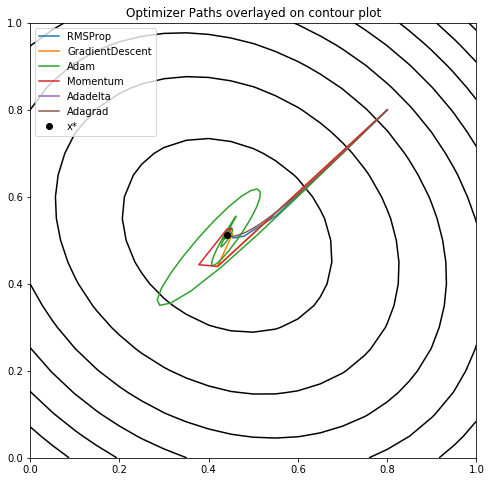

In [13]:
plt.figure(figsize=(8, 8))
plt.contour(grid[0], grid[1], z, samples // 3, colors='k')
leg = []
for optimizer in optimizers:
    leg.append(optimizer.get_name())
    obj = optimizer.minimize(objective)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        x_ = sess.run(x)
        pts = [ x_[:, 0] ]
        for step in range(epochs):
            sess.run(obj)
            x_ = sess.run(x)
            pts.append(x_[:, 0])
        pts = np.array(pts)
        plt.plot(pts[:,0], pts[:,1])
plt.plot(xstar[0], xstar[1], 'o', c='k')
leg.append('x*')
plt.legend(leg)
plt.title('Optimizer Paths overlayed on contour plot')
plt.show()

## References

* ["Introduction TensorFlow - Optimization of Objective Functions", Wieschollek, 2017](http://patwie.com/tutorials/tensorflow-optimization.html)
* [ScipyOptimizerInterface](https://www.tensorflow.org/api_docs/python/tf/contrib/opt/ScipyOptimizerInterface)
* [Constraint optimization? #2025](https://github.com/tensorflow/tensorflow/issues/2025)
* [Constrained linear regression using Tensorflow](https://nipunbatra.github.io/blog/2017/nn-linear-regression-tensorflow.html)
* [SciPy portfolio optimization with grouped by industry bounds](https://stackoverflow.com/questions/44515880/scipy-portfolio-optimization-with-grouped-by-industry-bounds)